In [ ]:
# pip install matplotlib

In [181]:
# pip install StratifiedKFold

ERROR: Could not find a version that satisfies the requirement StratifiedKFold (from versions: none)
ERROR: No matching distribution found for StratifiedKFold
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [303]:
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization,LeakyReLU

from tensorflow.keras.utils import image_dataset_from_directory
from sklearn.model_selection import train_test_split,StratifiedKFold ,GridSearchCV
from sklearn.metrics import classification_report,confusion_matrix
from keras.callbacks import ReduceLROnPlateau , ModelCheckpoint
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import RMSprop,Adam
# import cv2
import tensorflow as tf
import os
import pandas as pd
import numpy as np
import matplotlib.image as mpimg
import  splitfolders
from pathlib import  Path
import shutil

In [304]:
# drive.mount('/content/drive')
dir = '/root/chest_xray'

In [305]:
root_path = Path("/root/chest_xray")
target_path = Path("/root/images")
list_p = ['train','val','test']
def copy_file(root_path, target_path):
    # make sure the target path exists
    target_path.mkdir(exist_ok=True)
    # for each category in root path
    for dataset in root_path.glob("*"): # train / val / test
        if dataset.name not in list_p:
            continue
        for category in dataset.glob("*"): # NORMAL /....
            target_category = target_path / category.name # /root/images/NORMAL
            target_category.mkdir(exist_ok=True)
            for image in category.glob("*"): 
                shutil.copy(
                    src=image, # /root/chest_xray/train/NORMAL/
                    dst=target_category / image.name
                )

In [306]:
copy_file(root_path,target_path)

In [307]:
labels = ['PNEUMONIA' ,'NORMAL' ]
image_size = 150
def training_data(data_dir):
  data=[]
  for label in labels:
    path = os.path.join(data_dir , label)
    num_of_class=  labels.index(label)
    for image in os.listdir(path):
      try:
        image_arr = mpimg.imread(os.path.join(path, image))
       
        data.append([image_arr, num_of_class])
      except Exception as e:
           print(e)
  return np.array(data) 


In [308]:
train = training_data(dir+'/train')
test = training_data(dir+'/test')
val = training_data(dir + '/val')

/tmp/ipykernel_799/3125223304.py:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(data)


Text(0.5, 1.0, 'NORMAL')

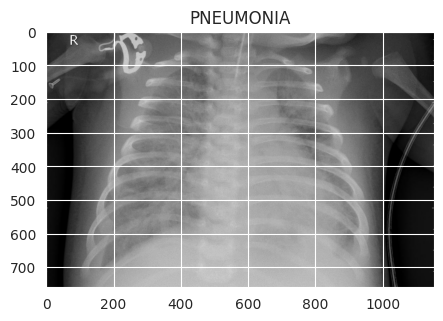

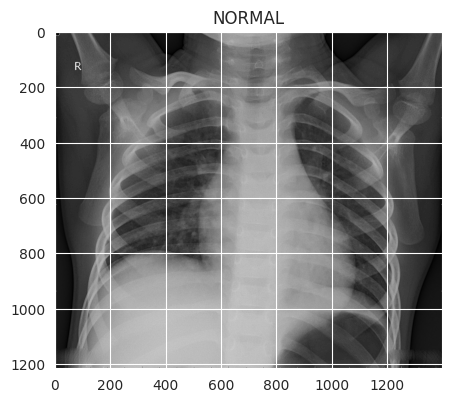

In [310]:
plt.figure(figsize=(5,5))
plt.imshow(train[0][0],cmap='gray')
plt.title(labels[train[0][1]])

plt.figure(figsize=(5,5))
plt.imshow(train[-1][0],cmap='gray')
plt.title(labels[train[-1][1]])

In [338]:
splitfolders.ratio("/root/images", output="output",
    seed=1337, ratio=(.8, .1, .1), group_prefix=None, move=False)

Copying files: 5856 files [00:05, 1156.94 files/s]


In [339]:
dir_d = '/root/output'
train_dataset = image_dataset_from_directory(
    dir_d+'/train',
    batch_size = 32,
    image_size=(image_size,image_size),
   )


val_dataset = image_dataset_from_directory(
    dir_d+'/val',
    batch_size = 32,
    image_size=(image_size,image_size),
    )


test_dataset = image_dataset_from_directory(
    dir_d+'/test',
    batch_size = 32,
    image_size=(image_size,image_size))


Found 4684 files belonging to 2 classes.
Found 1170 files belonging to 2 classes.
Found 1172 files belonging to 2 classes.


In [340]:

data_aug = Sequential([layers.RandomZoom(0.2),layers.RandomRotation(35),layers.RandomFlip("horizontal")])


In [341]:
model = Sequential()
model.add(layers.Input(shape= (150,150,3)))
model.add(data_aug)
model.add(layers.Rescaling(1.0/255))

# layer 1
model.add(Conv2D(32 , (3,3) , strides = 1 , padding = 'same'  ,))
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))

# layer 2
model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , ))
model.add(Dropout(0.2))
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))


# layer 3
model.add(Conv2D(128 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))

# layer 4
model.add(Conv2D(256 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
# Flatten layer 
model.add(Flatten())
#fully conected layer
model.add(Dense(units = 32 , activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(units = 1 , activation = 'sigmoid'))
model.compile(optimizer = 'Adam' , loss = 'binary_crossentropy' , metrics = ['accuracy'])
model.summary()


Model: "sequential_162"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_161 (Sequential)  (None, 150, 150, 3)      0         
                                                                 
 rescaling_67 (Rescaling)    (None, 150, 150, 3)       0         
                                                                 
 conv2d_152 (Conv2D)         (None, 150, 150, 32)      896       
                                                                 
 max_pooling2d_152 (MaxPooli  (None, 75, 75, 32)       0         
 ng2D)                                                           
                                                                 
 conv2d_153 (Conv2D)         (None, 75, 75, 64)        18496     
                                                                 
 dropout_268 (Dropout)       (None, 75, 75, 64)        0         
                                                    

In [342]:
learning_rate_reduction = [   ReduceLROnPlateau(monitor = 'val_loss', patience = 2, verbose=1,factor=0.3, min_lr=0.001),
            ModelCheckpoint("xray_model_v2.h5", monitor='val_loss', save_best_only=True)]

In [343]:
history = model.fit(train_dataset ,
                    epochs = 10 , validation_data = val_dataset ,callbacks = [learning_rate_reduction])

Epoch 1/10


2023-01-25 23:43:17.625289: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_162/dropout_268/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


147/147 [==============================] - 30s 159ms/step - loss: 0.5557 - accuracy: 0.7340 - val_loss: 0.4576 - val_accuracy: 0.7274 - lr: 0.0010
Epoch 2/10
147/147 [==============================] - 23s 154ms/step - loss: 0.4407 - accuracy: 0.7564 - val_loss: 0.3731 - val_accuracy: 0.8521 - lr: 0.0010
Epoch 3/10
147/147 [==============================] - 23s 153ms/step - loss: 0.4271 - accuracy: 0.8072 - val_loss: 0.3992 - val_accuracy: 0.7812 - lr: 0.0010
Epoch 4/10
147/147 [==============================] - 24s 157ms/step - loss: 0.3891 - accuracy: 0.8435 - val_loss: 0.3579 - val_accuracy: 0.8761 - lr: 0.0010
Epoch 5/10
147/147 [==============================] - 24s 156ms/step - loss: 0.4085 - accuracy: 0.8234 - val_loss: 0.3387 - val_accuracy: 0.8769 - lr: 0.0010
Epoch 6/10
147/147 [==============================] - 24s 157ms/step - loss: 0.3411 - accuracy: 0.8565 - val_loss: 0.2731 - val_accuracy: 0.9043 - lr: 0.0010
Epoch 7/10
147/147 [==============================] - 23s 156ms

In [344]:
print("acc "+  str(model.evaluate(test_dataset)[1]*100)+"%")#20
print("loss "+ str(model.evaluate(test_dataset)[0]))


print("acc "+  str(test_model.evaluate(test_dataset)[1]*100)+"%")#20
print("loss "+ str(test_model.evaluate(test_dataset)[0]))

37/37 [==============================] - 2s 46ms/step - loss: 0.2055 - accuracy: 0.9266
acc 92.662113904953%
37/37 [==============================] - 2s 46ms/step - loss: 0.2055 - accuracy: 0.9266
loss 0.20553149282932281
37/37 [==============================] - 2s 45ms/step - loss: 0.1663 - accuracy: 0.9471
acc 94.7098970413208%
37/37 [==============================] - 2s 45ms/step - loss: 0.1663 - accuracy: 0.9471
loss 0.16625425219535828


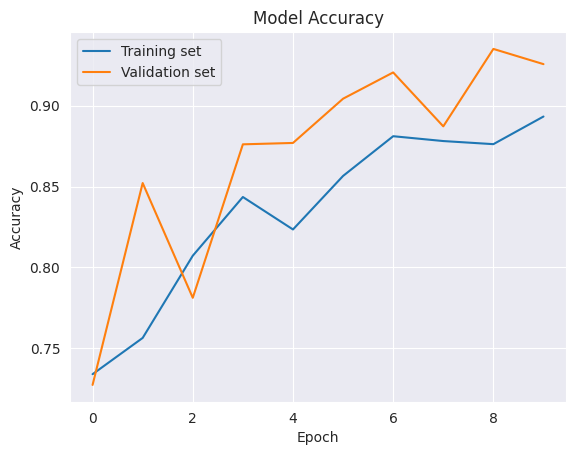

In [345]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training set', 'Validation set'], loc='upper left')
plt.show()

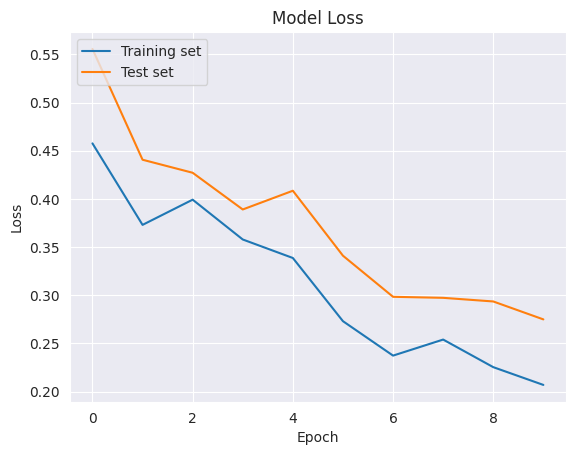

In [346]:

plt.plot(history.history['val_loss'])
plt.plot(history.history['loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training set', 'Test set'], loc='upper left')
plt.show()


In [347]:
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier


x_train =[]
y_train = []

x_val =[]
y_val = []

x_test =[]
y_test = []

for feature ,label in train_dataset:
    for i in feature:
         x_train.append(i)
            
    for i in label:
         y_train.append(i)





In [348]:
x_train =np.array(x_train)
y_train = np.array(y_train)

In [349]:
def Hperpatmetr_tunung(opt="adam",lr=0.01):
    optimizer = {'adam':keras.optimizers.Adam(learning_rate=lr),
           "SGD":keras.optimizers.SGD(learning_rate=lr)} 
        
    cnn = Sequential()
    cnn.add(layers.Input(shape= (150,150,3)))
    cnn.add(data_aug)
    cnn.add(layers.Rescaling(1.0/255))
    cnn.add(Conv2D(32 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
    cnn.add(Dropout(0.2))
    cnn.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))

    cnn.add(Flatten())
    cnn.add(Dense(units = 32 , activation = 'relu'))
    cnn.add(Dropout(0.2))
    cnn.add(Dense(units = 1 , activation = 'sigmoid'))
    cnn.compile(loss = "binary_crossentropy",metrics=['accuracy'],optimizer = optimizer[opt]) 
    return cnn

In [350]:
cnn_classifier = KerasClassifier(build_fn=Hperpatmetr_tunung, epochs=10, batch_size=128, verbose=1)
optmaizer = ['adam','SGD']
K_Fold = StratifiedKFold(n_splits=5, shuffle=True, random_state=123)

param = dict(opt = optmaizer,lr = [0.0001,0.001,0.01])
grid_cnn = GridSearchCV(estimator=cnn_classifier, param_grid=param, cv=K_Fold)

/tmp/ipykernel_799/389587875.py:1: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  cnn_classifier = KerasClassifier(build_fn=Hperpatmetr_tunung, epochs=10, batch_size=128, verbose=1)


In [351]:
result = grid_cnn.fit(x_train,y_train)

Epoch 1/10


2023-01-25 23:48:20.042417: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_163/dropout_272/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


30/30 [==============================] - 36s 1s/step - loss: 0.6839 - accuracy: 0.6661
Epoch 2/10
30/30 [==============================] - 31s 1s/step - loss: 0.5844 - accuracy: 0.7299
Epoch 3/10
30/30 [==============================] - 31s 1s/step - loss: 0.5483 - accuracy: 0.7299
Epoch 4/10
30/30 [==============================] - 31s 1s/step - loss: 0.5237 - accuracy: 0.7299
Epoch 5/10
30/30 [==============================] - 31s 1s/step - loss: 0.4934 - accuracy: 0.7299
Epoch 6/10
30/30 [==============================] - 31s 1s/step - loss: 0.4756 - accuracy: 0.7299
Epoch 7/10
30/30 [==============================] - 32s 1s/step - loss: 0.4527 - accuracy: 0.7299
Epoch 8/10
30/30 [==============================] - 32s 1s/step - loss: 0.4415 - accuracy: 0.7299
Epoch 9/10
30/30 [==============================] - 32s 1s/step - loss: 0.4350 - accuracy: 0.7299
Epoch 10/10
8/8 [==============================] - 0s 20ms/step - loss: 0.4505 - accuracy: 0.7289
Epoch 1/10


2023-01-25 23:53:41.983639: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_164/dropout_274/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


30/30 [==============================] - 33s 977ms/step - loss: 0.6952 - accuracy: 0.6974
Epoch 2/10
30/30 [==============================] - 30s 992ms/step - loss: 0.5894 - accuracy: 0.7297
Epoch 3/10
30/30 [==============================] - 30s 990ms/step - loss: 0.5677 - accuracy: 0.7297
Epoch 4/10
30/30 [==============================] - 30s 993ms/step - loss: 0.5431 - accuracy: 0.7297
Epoch 5/10
30/30 [==============================] - 30s 998ms/step - loss: 0.5133 - accuracy: 0.7297
Epoch 6/10
30/30 [==============================] - 30s 1s/step - loss: 0.4898 - accuracy: 0.7297
Epoch 7/10
30/30 [==============================] - 30s 1s/step - loss: 0.4761 - accuracy: 0.7297
Epoch 8/10
30/30 [==============================] - 30s 1s/step - loss: 0.4643 - accuracy: 0.7297
Epoch 9/10
30/30 [==============================] - 30s 996ms/step - loss: 0.4582 - accuracy: 0.7297
Epoch 10/10
8/8 [==============================] - 0s 16ms/step - loss: 0.4672 - accuracy: 0.7300
Epoch 1/10


2023-01-25 23:58:49.857794: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_165/dropout_276/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


30/30 [==============================] - 34s 987ms/step - loss: 0.6239 - accuracy: 0.6952
Epoch 2/10
30/30 [==============================] - 29s 975ms/step - loss: 0.5101 - accuracy: 0.7313
Epoch 3/10
30/30 [==============================] - 29s 979ms/step - loss: 0.4583 - accuracy: 0.7297
Epoch 4/10
30/30 [==============================] - 29s 972ms/step - loss: 0.4384 - accuracy: 0.7790
Epoch 5/10
30/30 [==============================] - 29s 979ms/step - loss: 0.4241 - accuracy: 0.7828
Epoch 6/10
30/30 [==============================] - 30s 992ms/step - loss: 0.4023 - accuracy: 0.8153
Epoch 7/10
30/30 [==============================] - 29s 972ms/step - loss: 0.4069 - accuracy: 0.8124
Epoch 8/10
30/30 [==============================] - 29s 958ms/step - loss: 0.3937 - accuracy: 0.8078
Epoch 9/10
30/30 [==============================] - 29s 977ms/step - loss: 0.3783 - accuracy: 0.8311
Epoch 10/10
8/8 [==============================] - 0s 15ms/step - loss: 0.4602 - accuracy: 0.8303
Epoc

2023-01-26 00:03:51.591192: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_166/dropout_278/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


30/30 [==============================] - 33s 978ms/step - loss: 0.7165 - accuracy: 0.7123
Epoch 2/10
30/30 [==============================] - 29s 959ms/step - loss: 0.5539 - accuracy: 0.7297
Epoch 3/10
30/30 [==============================] - 29s 966ms/step - loss: 0.5059 - accuracy: 0.7313
Epoch 4/10
30/30 [==============================] - 29s 965ms/step - loss: 0.4884 - accuracy: 0.7297
Epoch 5/10
30/30 [==============================] - 29s 957ms/step - loss: 0.4500 - accuracy: 0.7297
Epoch 6/10
30/30 [==============================] - 29s 954ms/step - loss: 0.4327 - accuracy: 0.7321
Epoch 7/10
30/30 [==============================] - 29s 975ms/step - loss: 0.4178 - accuracy: 0.8017
Epoch 8/10
30/30 [==============================] - 29s 973ms/step - loss: 0.4362 - accuracy: 0.7932
Epoch 9/10
30/30 [==============================] - 29s 957ms/step - loss: 0.3998 - accuracy: 0.8110
Epoch 10/10
8/8 [==============================] - 0s 15ms/step - loss: 0.4456 - accuracy: 0.8709
Epoc

2023-01-26 00:08:50.080201: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_167/dropout_280/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


30/30 [==============================] - 33s 990ms/step - loss: 0.6944 - accuracy: 0.6884
Epoch 2/10
30/30 [==============================] - 30s 996ms/step - loss: 0.5806 - accuracy: 0.7276
Epoch 3/10
30/30 [==============================] - 30s 998ms/step - loss: 0.5633 - accuracy: 0.7271
Epoch 4/10
30/30 [==============================] - 29s 971ms/step - loss: 0.5439 - accuracy: 0.7284
Epoch 5/10
30/30 [==============================] - 29s 982ms/step - loss: 0.5168 - accuracy: 0.7305
Epoch 6/10
30/30 [==============================] - 30s 1s/step - loss: 0.4936 - accuracy: 0.7503
Epoch 7/10
30/30 [==============================] - 29s 980ms/step - loss: 0.4651 - accuracy: 0.7700
Epoch 8/10
30/30 [==============================] - 30s 986ms/step - loss: 0.4422 - accuracy: 0.7844
Epoch 9/10
30/30 [==============================] - 30s 984ms/step - loss: 0.4337 - accuracy: 0.7980
Epoch 10/10
8/8 [==============================] - 0s 20ms/step - loss: 0.4396 - accuracy: 0.8568
Epoch 1

2023-01-26 00:13:55.111209: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_168/dropout_282/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


30/30 [==============================] - 33s 985ms/step - loss: 0.6476 - accuracy: 0.6381
Epoch 2/10
30/30 [==============================] - 30s 985ms/step - loss: 0.5964 - accuracy: 0.7291
Epoch 3/10
30/30 [==============================] - 29s 977ms/step - loss: 0.5976 - accuracy: 0.7280
Epoch 4/10
30/30 [==============================] - 29s 962ms/step - loss: 0.5930 - accuracy: 0.7299
Epoch 5/10
30/30 [==============================] - 29s 978ms/step - loss: 0.5887 - accuracy: 0.7291
Epoch 6/10
30/30 [==============================] - 29s 956ms/step - loss: 0.5857 - accuracy: 0.7294
Epoch 7/10
30/30 [==============================] - 29s 970ms/step - loss: 0.5842 - accuracy: 0.7294
Epoch 8/10
30/30 [==============================] - 29s 975ms/step - loss: 0.5867 - accuracy: 0.7291
Epoch 9/10
30/30 [==============================] - 29s 967ms/step - loss: 0.5841 - accuracy: 0.7305
Epoch 10/10
8/8 [==============================] - 0s 15ms/step - loss: 0.5869 - accuracy: 0.7289
Epoc

2023-01-26 00:18:57.809059: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_169/dropout_284/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


30/30 [==============================] - 35s 974ms/step - loss: 0.6239 - accuracy: 0.7032
Epoch 2/10
30/30 [==============================] - 30s 990ms/step - loss: 0.5929 - accuracy: 0.7297
Epoch 3/10
30/30 [==============================] - 29s 976ms/step - loss: 0.5887 - accuracy: 0.7299
Epoch 4/10
30/30 [==============================] - 29s 980ms/step - loss: 0.5910 - accuracy: 0.7288
Epoch 5/10
30/30 [==============================] - 29s 973ms/step - loss: 0.5850 - accuracy: 0.7297
Epoch 6/10
30/30 [==============================] - 29s 978ms/step - loss: 0.5833 - accuracy: 0.7297
Epoch 7/10
30/30 [==============================] - 29s 961ms/step - loss: 0.5851 - accuracy: 0.7297
Epoch 8/10
30/30 [==============================] - 29s 953ms/step - loss: 0.5828 - accuracy: 0.7299
Epoch 9/10
30/30 [==============================] - 29s 980ms/step - loss: 0.5803 - accuracy: 0.7299
Epoch 10/10
8/8 [==============================] - 0s 15ms/step - loss: 0.5840 - accuracy: 0.7300
Epoc

2023-01-26 00:23:58.936143: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_170/dropout_286/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


30/30 [==============================] - 33s 967ms/step - loss: 0.6300 - accuracy: 0.6896
Epoch 2/10
30/30 [==============================] - 29s 966ms/step - loss: 0.5941 - accuracy: 0.7299
Epoch 3/10
30/30 [==============================] - 30s 984ms/step - loss: 0.5930 - accuracy: 0.7299
Epoch 4/10
30/30 [==============================] - 29s 976ms/step - loss: 0.5880 - accuracy: 0.7286
Epoch 5/10
30/30 [==============================] - 30s 985ms/step - loss: 0.5870 - accuracy: 0.7315
Epoch 6/10
30/30 [==============================] - 29s 980ms/step - loss: 0.5804 - accuracy: 0.7288
Epoch 7/10
30/30 [==============================] - 30s 983ms/step - loss: 0.5835 - accuracy: 0.7307
Epoch 8/10
30/30 [==============================] - 29s 969ms/step - loss: 0.5820 - accuracy: 0.7302
Epoch 9/10
30/30 [==============================] - 29s 969ms/step - loss: 0.5813 - accuracy: 0.7302
Epoch 10/10
8/8 [==============================] - 0s 15ms/step - loss: 0.5784 - accuracy: 0.7300
Epoc

2023-01-26 00:28:59.866259: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_171/dropout_288/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


30/30 [==============================] - 33s 961ms/step - loss: 0.6093 - accuracy: 0.7232
Epoch 2/10
30/30 [==============================] - 29s 970ms/step - loss: 0.5952 - accuracy: 0.7302
Epoch 3/10
30/30 [==============================] - 29s 974ms/step - loss: 0.5915 - accuracy: 0.7297
Epoch 4/10
30/30 [==============================] - 29s 962ms/step - loss: 0.5913 - accuracy: 0.7294
Epoch 5/10
30/30 [==============================] - 29s 969ms/step - loss: 0.5907 - accuracy: 0.7294
Epoch 6/10
30/30 [==============================] - 30s 995ms/step - loss: 0.5850 - accuracy: 0.7294
Epoch 7/10
30/30 [==============================] - 31s 1s/step - loss: 0.5802 - accuracy: 0.7297
Epoch 8/10
30/30 [==============================] - 32s 1s/step - loss: 0.5757 - accuracy: 0.7297
Epoch 9/10
30/30 [==============================] - 31s 1s/step - loss: 0.5759 - accuracy: 0.7299
Epoch 10/10
8/8 [==============================] - 0s 16ms/step - loss: 0.5711 - accuracy: 0.7300
Epoch 1/10


2023-01-26 00:34:06.203324: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_172/dropout_290/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


30/30 [==============================] - 33s 974ms/step - loss: 0.6109 - accuracy: 0.7068
Epoch 2/10
30/30 [==============================] - 29s 973ms/step - loss: 0.5894 - accuracy: 0.7297
Epoch 3/10
30/30 [==============================] - 29s 973ms/step - loss: 0.5860 - accuracy: 0.7297
Epoch 4/10
30/30 [==============================] - 30s 985ms/step - loss: 0.5819 - accuracy: 0.7297
Epoch 5/10
30/30 [==============================] - 29s 970ms/step - loss: 0.5837 - accuracy: 0.7297
Epoch 6/10
30/30 [==============================] - 34s 1s/step - loss: 0.5805 - accuracy: 0.7297
Epoch 7/10
30/30 [==============================] - 30s 980ms/step - loss: 0.5762 - accuracy: 0.7297
Epoch 8/10
30/30 [==============================] - 29s 969ms/step - loss: 0.5748 - accuracy: 0.7303
Epoch 9/10
30/30 [==============================] - 29s 963ms/step - loss: 0.5735 - accuracy: 0.7297
Epoch 10/10
8/8 [==============================] - 0s 15ms/step - loss: 0.5702 - accuracy: 0.7297
Epoch 1

2023-01-26 00:39:11.383094: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_173/dropout_292/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


30/30 [==============================] - 34s 1s/step - loss: 2.7191 - accuracy: 0.6240
Epoch 2/10
30/30 [==============================] - 30s 988ms/step - loss: 0.6032 - accuracy: 0.7299
Epoch 3/10
30/30 [==============================] - 29s 972ms/step - loss: 0.5869 - accuracy: 0.7299
Epoch 4/10
30/30 [==============================] - 29s 962ms/step - loss: 0.5691 - accuracy: 0.7299
Epoch 5/10
30/30 [==============================] - 29s 969ms/step - loss: 0.5505 - accuracy: 0.7299
Epoch 6/10
30/30 [==============================] - 30s 1s/step - loss: 0.5334 - accuracy: 0.7299
Epoch 7/10
30/30 [==============================] - 29s 975ms/step - loss: 0.5088 - accuracy: 0.7299
Epoch 8/10
30/30 [==============================] - 29s 970ms/step - loss: 0.4877 - accuracy: 0.7299
Epoch 9/10
30/30 [==============================] - 29s 961ms/step - loss: 0.4880 - accuracy: 0.7299
Epoch 10/10
8/8 [==============================] - 0s 15ms/step - loss: 0.5305 - accuracy: 0.7289
Epoch 1/10

2023-01-26 00:44:13.231114: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_174/dropout_294/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


30/30 [==============================] - 35s 1s/step - loss: 1.2467 - accuracy: 0.6576
Epoch 2/10
30/30 [==============================] - 31s 1s/step - loss: 0.5578 - accuracy: 0.7297
Epoch 3/10
30/30 [==============================] - 30s 987ms/step - loss: 0.5227 - accuracy: 0.7302
Epoch 4/10
30/30 [==============================] - 30s 986ms/step - loss: 0.4810 - accuracy: 0.7297
Epoch 5/10
30/30 [==============================] - 29s 975ms/step - loss: 0.4306 - accuracy: 0.7297
Epoch 6/10
30/30 [==============================] - 31s 1s/step - loss: 0.4129 - accuracy: 0.7374
Epoch 7/10
30/30 [==============================] - 29s 976ms/step - loss: 0.4177 - accuracy: 0.8110
Epoch 8/10
30/30 [==============================] - 29s 968ms/step - loss: 0.4074 - accuracy: 0.8353
Epoch 9/10
30/30 [==============================] - 29s 964ms/step - loss: 0.3831 - accuracy: 0.8369
Epoch 10/10
8/8 [==============================] - 0s 16ms/step - loss: 0.4090 - accuracy: 0.8751
Epoch 1/10


2023-01-26 00:49:19.126564: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_175/dropout_296/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


30/30 [==============================] - 35s 1s/step - loss: 2.0837 - accuracy: 0.6184
Epoch 2/10
30/30 [==============================] - 30s 999ms/step - loss: 0.5923 - accuracy: 0.7297
Epoch 3/10
30/30 [==============================] - 29s 978ms/step - loss: 0.5351 - accuracy: 0.7297
Epoch 4/10
30/30 [==============================] - 30s 991ms/step - loss: 0.5082 - accuracy: 0.7297
Epoch 5/10
30/30 [==============================] - 30s 1s/step - loss: 0.4724 - accuracy: 0.7297
Epoch 6/10
30/30 [==============================] - 31s 1s/step - loss: 0.4558 - accuracy: 0.7297
Epoch 7/10
30/30 [==============================] - 30s 984ms/step - loss: 0.4645 - accuracy: 0.7297
Epoch 8/10
30/30 [==============================] - 29s 973ms/step - loss: 0.4563 - accuracy: 0.7297
Epoch 9/10
30/30 [==============================] - 29s 973ms/step - loss: 0.4482 - accuracy: 0.7297
Epoch 10/10
8/8 [==============================] - 0s 15ms/step - loss: 0.4021 - accuracy: 0.7300
Epoch 1/10


2023-01-26 00:54:28.790899: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_176/dropout_298/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


30/30 [==============================] - 37s 1s/step - loss: 1.0716 - accuracy: 0.6944
Epoch 2/10
30/30 [==============================] - 30s 982ms/step - loss: 0.5273 - accuracy: 0.7264
Epoch 3/10
30/30 [==============================] - 30s 985ms/step - loss: 0.4562 - accuracy: 0.7297
Epoch 4/10
30/30 [==============================] - 29s 974ms/step - loss: 0.4498 - accuracy: 0.7297
Epoch 5/10
30/30 [==============================] - 30s 985ms/step - loss: 0.4180 - accuracy: 0.8062
Epoch 6/10
30/30 [==============================] - 31s 1s/step - loss: 0.3993 - accuracy: 0.8225
Epoch 7/10
30/30 [==============================] - 30s 984ms/step - loss: 0.4175 - accuracy: 0.8185
Epoch 8/10
30/30 [==============================] - 29s 979ms/step - loss: 0.3951 - accuracy: 0.8271
Epoch 9/10
30/30 [==============================] - 29s 977ms/step - loss: 0.3791 - accuracy: 0.8455
Epoch 10/10
8/8 [==============================] - 0s 15ms/step - loss: 0.4333 - accuracy: 0.8047
Epoch 1/10

2023-01-26 00:59:34.681568: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_177/dropout_300/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


30/30 [==============================] - 35s 1s/step - loss: 1.2186 - accuracy: 0.6788
Epoch 2/10
30/30 [==============================] - 29s 965ms/step - loss: 0.5049 - accuracy: 0.7297
Epoch 3/10
30/30 [==============================] - 30s 989ms/step - loss: 0.4667 - accuracy: 0.7297
Epoch 4/10
30/30 [==============================] - 29s 962ms/step - loss: 0.4585 - accuracy: 0.7583
Epoch 5/10
30/30 [==============================] - 29s 966ms/step - loss: 0.4239 - accuracy: 0.7980
Epoch 6/10
30/30 [==============================] - 30s 1s/step - loss: 0.4007 - accuracy: 0.8287
Epoch 7/10
30/30 [==============================] - 29s 959ms/step - loss: 0.3994 - accuracy: 0.8303
Epoch 8/10
30/30 [==============================] - 29s 960ms/step - loss: 0.4054 - accuracy: 0.8255
Epoch 9/10
30/30 [==============================] - 29s 951ms/step - loss: 0.4073 - accuracy: 0.8212
Epoch 10/10
8/8 [==============================] - 0s 14ms/step - loss: 0.4173 - accuracy: 0.8269
Epoch 1/10

2023-01-26 01:04:35.488697: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_178/dropout_302/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


30/30 [==============================] - 33s 960ms/step - loss: 0.5881 - accuracy: 0.7166
Epoch 2/10
30/30 [==============================] - 29s 979ms/step - loss: 0.5703 - accuracy: 0.7299
Epoch 3/10
30/30 [==============================] - 29s 961ms/step - loss: 0.5538 - accuracy: 0.7302
Epoch 4/10
30/30 [==============================] - 29s 959ms/step - loss: 0.5415 - accuracy: 0.7302
Epoch 5/10
30/30 [==============================] - 29s 969ms/step - loss: 0.5340 - accuracy: 0.7315
Epoch 6/10
30/30 [==============================] - 30s 1s/step - loss: 0.5227 - accuracy: 0.7401
Epoch 7/10
30/30 [==============================] - 29s 979ms/step - loss: 0.5123 - accuracy: 0.7478
Epoch 8/10
30/30 [==============================] - 30s 984ms/step - loss: 0.5000 - accuracy: 0.7537
Epoch 9/10
30/30 [==============================] - 30s 984ms/step - loss: 0.4955 - accuracy: 0.7603
Epoch 10/10
8/8 [==============================] - 0s 15ms/step - loss: 0.6499 - accuracy: 0.5955
Epoch 1

2023-01-26 01:09:36.572771: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_179/dropout_304/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


30/30 [==============================] - 34s 1s/step - loss: 0.5892 - accuracy: 0.7297
Epoch 2/10
30/30 [==============================] - 30s 1s/step - loss: 0.5649 - accuracy: 0.7297
Epoch 3/10
30/30 [==============================] - 30s 1s/step - loss: 0.5543 - accuracy: 0.7302
Epoch 4/10
30/30 [==============================] - 30s 1s/step - loss: 0.5373 - accuracy: 0.7299
Epoch 5/10
30/30 [==============================] - 30s 987ms/step - loss: 0.5319 - accuracy: 0.7361
Epoch 6/10
30/30 [==============================] - 31s 1s/step - loss: 0.5179 - accuracy: 0.7393
Epoch 7/10
30/30 [==============================] - 29s 970ms/step - loss: 0.5158 - accuracy: 0.7427
Epoch 8/10
30/30 [==============================] - 30s 986ms/step - loss: 0.4987 - accuracy: 0.7558
Epoch 9/10
30/30 [==============================] - 30s 986ms/step - loss: 0.4860 - accuracy: 0.7595
Epoch 10/10
8/8 [==============================] - 0s 14ms/step - loss: 0.4838 - accuracy: 0.8239
Epoch 1/10


2023-01-26 01:14:44.528451: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_180/dropout_306/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


30/30 [==============================] - 33s 967ms/step - loss: 0.6029 - accuracy: 0.7104
Epoch 2/10
30/30 [==============================] - 31s 1s/step - loss: 0.5735 - accuracy: 0.7297
Epoch 3/10
30/30 [==============================] - 29s 980ms/step - loss: 0.5662 - accuracy: 0.7297
Epoch 4/10
30/30 [==============================] - 30s 985ms/step - loss: 0.5549 - accuracy: 0.7299
Epoch 5/10
30/30 [==============================] - 29s 958ms/step - loss: 0.5452 - accuracy: 0.7302
Epoch 6/10
30/30 [==============================] - 29s 971ms/step - loss: 0.5406 - accuracy: 0.7318
Epoch 7/10
30/30 [==============================] - 30s 1s/step - loss: 0.5300 - accuracy: 0.7350
Epoch 8/10
30/30 [==============================] - 29s 961ms/step - loss: 0.5200 - accuracy: 0.7374
Epoch 9/10
30/30 [==============================] - 29s 963ms/step - loss: 0.5162 - accuracy: 0.7403
Epoch 10/10
8/8 [==============================] - 0s 14ms/step - loss: 0.5038 - accuracy: 0.7300
Epoch 1/10

2023-01-26 01:19:46.282326: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_181/dropout_308/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


30/30 [==============================] - 32s 962ms/step - loss: 0.5836 - accuracy: 0.7203
Epoch 2/10
30/30 [==============================] - 29s 963ms/step - loss: 0.5673 - accuracy: 0.7305
Epoch 3/10
30/30 [==============================] - 31s 1s/step - loss: 0.5609 - accuracy: 0.7299
Epoch 4/10
30/30 [==============================] - 30s 992ms/step - loss: 0.5438 - accuracy: 0.7334
Epoch 5/10
30/30 [==============================] - 30s 995ms/step - loss: 0.5356 - accuracy: 0.7347
Epoch 6/10
30/30 [==============================] - 29s 974ms/step - loss: 0.5223 - accuracy: 0.7427
Epoch 7/10
30/30 [==============================] - 30s 1s/step - loss: 0.5155 - accuracy: 0.7475
Epoch 8/10
30/30 [==============================] - 31s 1s/step - loss: 0.5089 - accuracy: 0.7534
Epoch 9/10
30/30 [==============================] - 29s 979ms/step - loss: 0.5012 - accuracy: 0.7627
Epoch 10/10
8/8 [==============================] - 0s 15ms/step - loss: 0.4813 - accuracy: 0.7428
Epoch 1/10


2023-01-26 01:24:52.185587: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_182/dropout_310/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


30/30 [==============================] - 33s 967ms/step - loss: 0.5947 - accuracy: 0.7164
Epoch 2/10
30/30 [==============================] - 30s 997ms/step - loss: 0.5718 - accuracy: 0.7297
Epoch 3/10
30/30 [==============================] - 35s 1s/step - loss: 0.5582 - accuracy: 0.7295
Epoch 4/10
30/30 [==============================] - 30s 983ms/step - loss: 0.5487 - accuracy: 0.7297
Epoch 5/10
30/30 [==============================] - 31s 1s/step - loss: 0.5375 - accuracy: 0.7313
Epoch 6/10
30/30 [==============================] - 30s 1s/step - loss: 0.5297 - accuracy: 0.7369
Epoch 7/10
30/30 [==============================] - 32s 1s/step - loss: 0.5119 - accuracy: 0.7468
Epoch 8/10
30/30 [==============================] - 31s 1s/step - loss: 0.5097 - accuracy: 0.7495
Epoch 9/10
30/30 [==============================] - 31s 1s/step - loss: 0.4986 - accuracy: 0.7524
Epoch 10/10
8/8 [==============================] - 0s 15ms/step - loss: 0.5327 - accuracy: 0.8526
Epoch 1/10


2023-01-26 01:30:13.169606: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_183/dropout_312/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


30/30 [==============================] - 38s 1s/step - loss: 5.0598 - accuracy: 0.7040
Epoch 2/10
30/30 [==============================] - 31s 1s/step - loss: 0.5976 - accuracy: 0.7299
Epoch 3/10
30/30 [==============================] - 32s 1s/step - loss: 0.5841 - accuracy: 0.7299
Epoch 4/10
30/30 [==============================] - 30s 1s/step - loss: 0.5866 - accuracy: 0.7299
Epoch 5/10
30/30 [==============================] - 30s 1s/step - loss: 0.5854 - accuracy: 0.7299
Epoch 6/10
30/30 [==============================] - 31s 1s/step - loss: 0.5863 - accuracy: 0.7299
Epoch 7/10
30/30 [==============================] - 32s 1s/step - loss: 0.5876 - accuracy: 0.7299
Epoch 8/10
30/30 [==============================] - 32s 1s/step - loss: 0.5842 - accuracy: 0.7299
Epoch 9/10
30/30 [==============================] - 31s 1s/step - loss: 0.5858 - accuracy: 0.7299
Epoch 10/10
8/8 [==============================] - 0s 15ms/step - loss: 0.5847 - accuracy: 0.7289
Epoch 1/10


2023-01-26 01:35:30.812679: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_184/dropout_314/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


30/30 [==============================] - 33s 989ms/step - loss: 6.3454 - accuracy: 0.6768
Epoch 2/10
30/30 [==============================] - 32s 1s/step - loss: 0.6173 - accuracy: 0.7297
Epoch 3/10
30/30 [==============================] - 30s 1s/step - loss: 0.5662 - accuracy: 0.7297
Epoch 4/10
30/30 [==============================] - 29s 982ms/step - loss: 0.5466 - accuracy: 0.7251
Epoch 5/10
30/30 [==============================] - 30s 1000ms/step - loss: 0.5430 - accuracy: 0.7294
Epoch 6/10
30/30 [==============================] - 30s 991ms/step - loss: 0.5434 - accuracy: 0.7291
Epoch 7/10
30/30 [==============================] - 32s 1s/step - loss: 0.5347 - accuracy: 0.7315
Epoch 8/10
30/30 [==============================] - 30s 1s/step - loss: 0.5356 - accuracy: 0.7361
Epoch 9/10
30/30 [==============================] - 30s 1s/step - loss: 0.5426 - accuracy: 0.7310
Epoch 10/10
8/8 [==============================] - 0s 15ms/step - loss: 0.4926 - accuracy: 0.7353
Epoch 1/10


2023-01-26 01:40:42.332637: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_185/dropout_316/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


30/30 [==============================] - 33s 987ms/step - loss: 7.3078 - accuracy: 0.7030
Epoch 2/10
30/30 [==============================] - 32s 1s/step - loss: 0.5748 - accuracy: 0.7297
Epoch 3/10
30/30 [==============================] - 29s 975ms/step - loss: 0.5493 - accuracy: 0.7297
Epoch 4/10
30/30 [==============================] - 29s 981ms/step - loss: 0.5359 - accuracy: 0.7297
Epoch 5/10
30/30 [==============================] - 29s 979ms/step - loss: 0.5381 - accuracy: 0.7286
Epoch 6/10
30/30 [==============================] - 30s 997ms/step - loss: 0.5350 - accuracy: 0.7297
Epoch 7/10
30/30 [==============================] - 31s 1s/step - loss: 0.5315 - accuracy: 0.7297
Epoch 8/10
30/30 [==============================] - 30s 1s/step - loss: 0.5297 - accuracy: 0.7297
Epoch 9/10
30/30 [==============================] - 29s 977ms/step - loss: 0.5440 - accuracy: 0.7262
Epoch 10/10
8/8 [==============================] - 0s 15ms/step - loss: 0.4931 - accuracy: 0.7300
Epoch 1/10


2023-01-26 01:45:50.258094: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_186/dropout_318/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


30/30 [==============================] - 33s 974ms/step - loss: 11.5068 - accuracy: 0.6984
Epoch 2/10
30/30 [==============================] - 31s 1s/step - loss: 0.6043 - accuracy: 0.7297
Epoch 3/10
30/30 [==============================] - 31s 1s/step - loss: 0.5598 - accuracy: 0.7297
Epoch 4/10
30/30 [==============================] - 30s 992ms/step - loss: 0.5460 - accuracy: 0.7307
Epoch 5/10
30/30 [==============================] - 30s 999ms/step - loss: 0.5480 - accuracy: 0.7272
Epoch 6/10
30/30 [==============================] - 29s 979ms/step - loss: 0.5390 - accuracy: 0.7329
Epoch 7/10
30/30 [==============================] - 31s 1s/step - loss: 0.5431 - accuracy: 0.7318
Epoch 8/10
30/30 [==============================] - 30s 991ms/step - loss: 0.5399 - accuracy: 0.7342
Epoch 9/10
30/30 [==============================] - 29s 979ms/step - loss: 0.5365 - accuracy: 0.7323
Epoch 10/10
8/8 [==============================] - 0s 16ms/step - loss: 0.5132 - accuracy: 0.7257
Epoch 1/10


2023-01-26 01:50:58.728543: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_187/dropout_320/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


30/30 [==============================] - 33s 977ms/step - loss: 7.9652 - accuracy: 0.6593
Epoch 2/10
30/30 [==============================] - 32s 1s/step - loss: 0.6118 - accuracy: 0.7303
Epoch 3/10
30/30 [==============================] - 29s 972ms/step - loss: 0.5764 - accuracy: 0.7300
Epoch 4/10
30/30 [==============================] - 30s 1s/step - loss: 0.5513 - accuracy: 0.7279
Epoch 5/10
30/30 [==============================] - 30s 998ms/step - loss: 0.5490 - accuracy: 0.7300
Epoch 6/10
30/30 [==============================] - 30s 1s/step - loss: 0.5434 - accuracy: 0.7332
Epoch 7/10
30/30 [==============================] - 32s 1s/step - loss: 0.5397 - accuracy: 0.7340
Epoch 8/10
30/30 [==============================] - 31s 1s/step - loss: 0.5338 - accuracy: 0.7324
Epoch 9/10
30/30 [==============================] - 30s 1s/step - loss: 0.5321 - accuracy: 0.7353
Epoch 10/10
8/8 [==============================] - 0s 14ms/step - loss: 0.4779 - accuracy: 0.7639
Epoch 1/10


2023-01-26 01:56:09.301786: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_188/dropout_322/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


30/30 [==============================] - 35s 1s/step - loss: 0.6760 - accuracy: 0.7222
Epoch 2/10
30/30 [==============================] - 31s 1s/step - loss: 0.5941 - accuracy: 0.7294
Epoch 3/10
30/30 [==============================] - 30s 1000ms/step - loss: 0.5791 - accuracy: 0.7286
Epoch 4/10
30/30 [==============================] - 30s 997ms/step - loss: 0.5724 - accuracy: 0.7297
Epoch 5/10
30/30 [==============================] - 30s 1s/step - loss: 0.5568 - accuracy: 0.7299
Epoch 6/10
30/30 [==============================] - 31s 1s/step - loss: 0.5448 - accuracy: 0.7315
Epoch 7/10
30/30 [==============================] - 30s 1s/step - loss: 0.5318 - accuracy: 0.7411
Epoch 8/10
30/30 [==============================] - 30s 988ms/step - loss: 0.5220 - accuracy: 0.7561
Epoch 9/10
30/30 [==============================] - 29s 985ms/step - loss: 0.5082 - accuracy: 0.7601
Epoch 10/10
8/8 [==============================] - 0s 15ms/step - loss: 0.4647 - accuracy: 0.7375
Epoch 1/10


2023-01-26 02:01:19.855125: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_189/dropout_324/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


30/30 [==============================] - 34s 1s/step - loss: 0.6728 - accuracy: 0.7208
Epoch 2/10
30/30 [==============================] - 30s 986ms/step - loss: 0.5792 - accuracy: 0.7294
Epoch 3/10
30/30 [==============================] - 29s 973ms/step - loss: 0.5715 - accuracy: 0.7297
Epoch 4/10
30/30 [==============================] - 29s 980ms/step - loss: 0.5539 - accuracy: 0.7297
Epoch 5/10
30/30 [==============================] - 29s 976ms/step - loss: 0.5396 - accuracy: 0.7297
Epoch 6/10
30/30 [==============================] - 31s 1s/step - loss: 0.5318 - accuracy: 0.7305
Epoch 7/10
30/30 [==============================] - 30s 997ms/step - loss: 0.5304 - accuracy: 0.7310
Epoch 8/10
30/30 [==============================] - 29s 983ms/step - loss: 0.5240 - accuracy: 0.7305
Epoch 9/10
30/30 [==============================] - 30s 982ms/step - loss: 0.5043 - accuracy: 0.7366
Epoch 10/10
8/8 [==============================] - 0s 16ms/step - loss: 0.5613 - accuracy: 0.8239
Epoch 1/10

2023-01-26 02:06:30.462784: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_190/dropout_326/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


30/30 [==============================] - 38s 998ms/step - loss: 0.6479 - accuracy: 0.7131
Epoch 2/10
30/30 [==============================] - 30s 1s/step - loss: 0.5758 - accuracy: 0.7297
Epoch 3/10
30/30 [==============================] - 30s 999ms/step - loss: 0.5542 - accuracy: 0.7297
Epoch 4/10
30/30 [==============================] - 30s 995ms/step - loss: 0.5467 - accuracy: 0.7299
Epoch 5/10
30/30 [==============================] - 31s 1s/step - loss: 0.5175 - accuracy: 0.7326
Epoch 6/10
30/30 [==============================] - 31s 1s/step - loss: 0.5236 - accuracy: 0.7438
Epoch 7/10
30/30 [==============================] - 30s 986ms/step - loss: 0.4841 - accuracy: 0.7534
Epoch 8/10
30/30 [==============================] - 30s 1s/step - loss: 0.4976 - accuracy: 0.7630
Epoch 9/10
30/30 [==============================] - 30s 987ms/step - loss: 0.4533 - accuracy: 0.7830
Epoch 10/10
8/8 [==============================] - 1s 16ms/step - loss: 0.4255 - accuracy: 0.7716
Epoch 1/10


2023-01-26 02:11:42.050398: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_191/dropout_328/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


30/30 [==============================] - 33s 993ms/step - loss: 0.6188 - accuracy: 0.7232
Epoch 2/10
30/30 [==============================] - 30s 998ms/step - loss: 0.5841 - accuracy: 0.7297
Epoch 3/10
30/30 [==============================] - 30s 989ms/step - loss: 0.5645 - accuracy: 0.7302
Epoch 4/10
30/30 [==============================] - 30s 987ms/step - loss: 0.5536 - accuracy: 0.7318
Epoch 5/10
30/30 [==============================] - 32s 1s/step - loss: 0.5484 - accuracy: 0.7305
Epoch 6/10
30/30 [==============================] - 30s 992ms/step - loss: 0.5462 - accuracy: 0.7299
Epoch 7/10
30/30 [==============================] - 30s 989ms/step - loss: 0.5229 - accuracy: 0.7353
Epoch 8/10
30/30 [==============================] - 30s 983ms/step - loss: 0.5333 - accuracy: 0.7518
Epoch 9/10
30/30 [==============================] - 30s 984ms/step - loss: 0.5184 - accuracy: 0.7553
Epoch 10/10
8/8 [==============================] - 0s 15ms/step - loss: 0.4844 - accuracy: 0.7300
Epoch 1

2023-01-26 02:16:51.062339: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_192/dropout_330/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


30/30 [==============================] - 33s 987ms/step - loss: 0.6446 - accuracy: 0.7129
Epoch 2/10
30/30 [==============================] - 30s 985ms/step - loss: 0.5851 - accuracy: 0.7297
Epoch 3/10
30/30 [==============================] - 30s 990ms/step - loss: 0.5667 - accuracy: 0.7297
Epoch 4/10
30/30 [==============================] - 30s 981ms/step - loss: 0.5701 - accuracy: 0.7297
Epoch 5/10
30/30 [==============================] - 31s 1s/step - loss: 0.5590 - accuracy: 0.7295
Epoch 6/10
30/30 [==============================] - 30s 1s/step - loss: 0.5639 - accuracy: 0.7295
Epoch 7/10
30/30 [==============================] - 30s 986ms/step - loss: 0.5321 - accuracy: 0.7300
Epoch 8/10
30/30 [==============================] - 30s 986ms/step - loss: 0.5263 - accuracy: 0.7297
Epoch 9/10
30/30 [==============================] - 30s 987ms/step - loss: 0.5238 - accuracy: 0.7297
Epoch 10/10
8/8 [==============================] - 0s 14ms/step - loss: 0.4976 - accuracy: 0.7297
Epoch 1/10

2023-01-26 02:21:59.848560: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_193/dropout_332/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


37/37 [==============================] - 40s 993ms/step - loss: 0.6905 - accuracy: 0.6975
Epoch 2/10
37/37 [==============================] - 37s 995ms/step - loss: 0.5696 - accuracy: 0.7297
Epoch 3/10
37/37 [==============================] - 37s 993ms/step - loss: 0.5375 - accuracy: 0.7297
Epoch 4/10
37/37 [==============================] - 39s 1s/step - loss: 0.4843 - accuracy: 0.7297
Epoch 5/10
37/37 [==============================] - 37s 1s/step - loss: 0.4498 - accuracy: 0.7297
Epoch 6/10
37/37 [==============================] - 37s 997ms/step - loss: 0.4195 - accuracy: 0.7297
Epoch 7/10
37/37 [==============================] - 37s 1s/step - loss: 0.4054 - accuracy: 0.7562
Epoch 8/10
37/37 [==============================] - 39s 1s/step - loss: 0.4064 - accuracy: 0.8209
Epoch 9/10
37/37 [==============================] - 37s 1s/step - loss: 0.4038 - accuracy: 0.8330
Epoch 10/10
37/37 [==============================] - 37s 1s/step - loss: 0.3906 - accuracy: 0.8316


In [352]:
print("Best acc: %f %s" % (result.best_score_, result.best_params_))

means = result.cv_results_['mean_test_score']
stds = result.cv_results_['std_test_score']
params = result.cv_results_['params']

for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best acc: 0.803385 {'lr': 0.0001, 'opt': 'adam'}
0.803385 (0.061753) with: {'lr': 0.0001, 'opt': 'adam'}
0.729718 (0.000413) with: {'lr': 0.0001, 'opt': 'SGD'}
0.793133 (0.056762) with: {'lr': 0.001, 'opt': 'adam'}
0.748955 (0.089770) with: {'lr': 0.001, 'opt': 'SGD'}
0.736769 (0.013908) with: {'lr': 0.01, 'opt': 'adam'}
0.758534 (0.036152) with: {'lr': 0.01, 'opt': 'SGD'}
